# OSM Processing

## Import Packages

In [2]:
import os
import geopandas as gpd
import pandas as pd
import pickle
from pathlib import Path

# Set Directory:

In [3]:
user_directory = os.fspath(Path.home()) #get home directory and convert to path string
file_directory = r"/Documents/BikewaySimData" #directory of bikewaysim outputs
os.chdir(user_directory+file_directory)

## Import custom modules

In [4]:
from osm_dwnld import * #contains functions for downloaded data from OSMnx and Overpass API

## Choose Study Area

<AxesSubplot:>

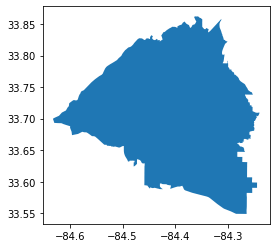

In [5]:
#give filepath of a shapefile/geojson/geopackage
#studyareafp = r'base_shapefiles/bikewaysim_study_area/bikewaysim_study_area.shp'
studyareafp = r'base_shapefiles/studyareas/district5.geojson'
#studyareafp = r'base_shapefiles/coa/Atlanta_City_Limits.shp'
#studyareafp = r'base_shapefiles/arc/arc_bounds.shp'
#studyareafp = r'processed_shapefiles\bike_transit\all_stops_buffer.geojson'

#give study area a name for exporting
studyareaname = 'district5'
#studyareaname = 'bikewaysim'
#studyareaname = 'coa'
#studyareaname = 'arc'
#studyareaname = 'marta'

#read in study area polygon and convert to WGS 84
gdf = gpd.read_file(studyareafp).to_crs(epsg=4326)
gdf.plot()

## Download OSM geometry using OSMnx and attribute data using Overpass API
### More info about OSMnx: https://geoffboeing.com/2016/11/osmnx-python-street-networks/
### OSMnx documentation: https://osmnx.readthedocs.io/en/stable/index.html

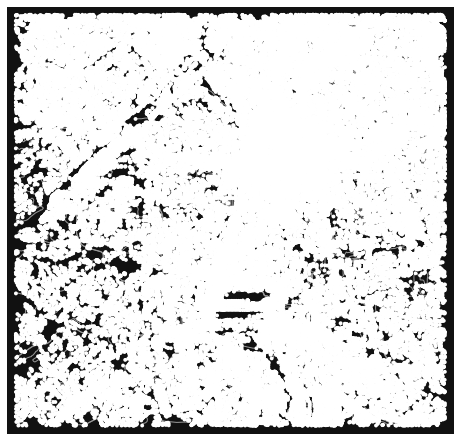

The bounding box is -84.63264879494459, 33.54892121680867, -84.23913659540551, 33.862268436683834


/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/osm_dwnld.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r'tags.', '')


In [7]:
osm_nodes, osm_links = download_osm(gdf)

In [8]:
osm_nodes.head()

,osmid,y,x,street_count,highway,ref,geometry
0,67358015,33.639735,-84.323721,3,NaN,NaN,POINT (-84.32372 33.63974)
1,67358019,33.638759,-84.323691,3,NaN,NaN,POINT (-84.32369 33.63876)
2,67358022,33.637772,-84.323717,3,NaN,NaN,POINT (-84.32372 33.63777)
3,67358027,33.637348,-84.323731,3,NaN,NaN,POINT (-84.32373 33.63735)
4,67358031,33.636202,-84.323741,2,NaN,NaN,POINT (-84.32374 33.63620)


In [9]:
osm_links.head()

,osmid,A,B,key,geometry,type,id,nodes,highway,name,...,dog,conveying,parking:lane,bench,bin,shelter,sidewalk:left,sidewalk:right,lat,lon
0,9106163,67358015,67358019,0,"LINESTRING (-84.32369 33.63876, -84.32368 33.6...",way,9106163,"[67358015, 67358018, 67358019, 67358022, 67358...",residential,Rocklane Drive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9106163,67358019,67358022,0,"LINESTRING (-84.32372 33.63777, -84.32369 33.6...",way,9106163,"[67358015, 67358018, 67358019, 67358022, 67358...",residential,Rocklane Drive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9106163,67358022,67358027,0,"LINESTRING (-84.32373 33.63735, -84.32372 33.6...",way,9106163,"[67358015, 67358018, 67358019, 67358022, 67358...",residential,Rocklane Drive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9106163,67358027,67358031,0,"LINESTRING (-84.32374 33.63620, -84.32372 33.6...",way,9106163,"[67358015, 67358018, 67358019, 67358022, 67358...",residential,Rocklane Drive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9111908,67358015,783782570,0,"LINESTRING (-84.32218 33.63973, -84.32279 33.6...",way,9111908,"[67379305, 4864114274, 4864114276, 67433168, 4...",tertiary,Rock Cut Place,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
copyof =osm_links

Create a pickle file to store all the attributes

In [9]:
with open('processed_shapefiles/osm/attr.pkl', 'wb') as fh:
        pickle.dump(osm_links,fh)

Remove columns with unsupported datatypes

In [10]:
for col in osm_links.columns.tolist():
    if list in [type(x) for x in osm_links.loc[:,col]]:
        osm_links.drop(columns=col,inplace=True)
        print(f"{col} column removed...")        

nodes column removed...


#### Preprocess
- Remove controlled access roads
- Remove sidewalks and crosswalks unless they explicitly allow bikes

##used this for lime
#create filtered links
osm_links_filt = osm_links

#remove restricted access roads + sidewalks
restr_access = osm_links_filt['highway'].isin(['motorway','motorway_link'])
osm_links_filt = osm_links_filt[-restr_access]
        
#remove sidewalks unless bikes explicitly allowed
remove_sidewalks = (osm_links_filt['footway'].isin(['sidewalk','crossing'])) & (osm_links_filt['bicycle'] != 'yes')
osm_links_filt = osm_links_filt[-remove_sidewalks]

osm_links_filt = gpd.read_file('osm/for_lime/osm_links_lime_032222.geojson')

#remove nodes that aren't in filtered links
nodes = osm_links_filt['A'].append(osm_links_filt['B']).unique()
osm_nodes_filt = osm_nodes[osm_nodes['osmid'].isin(nodes)]

#export
cols = ['A','B','osmid','highway','geometry']
osm_nodes_filt.to_file('osm/for_lime/osm_nodes_lime.geojson',driver='GeoJSON')
osm_links_filt[cols].to_file('osm/for_lime/osm_links_lime.geojson',driver='GeoJSON')
osm_nodes_filt.to_file('osm/for_lime/osm_nodes_lime.shp')
osm_links_filt[cols].to_file('osm/for_lime/osm_links_lime.shp')

osm_links_filt = gpd.read_file('osm/for_lime/osm_links_lime_032222.geojson')

#remove nodes that aren't in filtered links
nodes = osm_links_filt['A'].append(osm_links_filt['B']).unique()
osm_nodes_filt = osm_nodes[osm_nodes['osmid'].isin(nodes)]

osm_nodes_filt.to_file('osm/for_lime/osm_nodes_lime_032222.geojson',driver='GeoJSON')
osm_nodes_filt.to_file('osm/for_lime/osm_nodes_lime_032222.shp')
osm_links_filt.to_file('osm/for_lime/osm_links_lime_032222.shp')

OPTIONAL: Only keep necessary columns for filtering (will speed up writing process)

### Export as GeoJSON (not ideal but can keep all attributes)

In [11]:
#osm_nodes.to_file(f'base_shapefiles/osm/osm_nodes_{studyareaname}.geojson',driver='GeoJSON')

In [12]:
#osm_links.to_file(f'base_shapefiles/osm/osm_links_{studyareaname}.geojson',driver='GeoJSON')

### Export as GPKG (have issues with doing this because of the attributes data)

<AxesSubplot:>

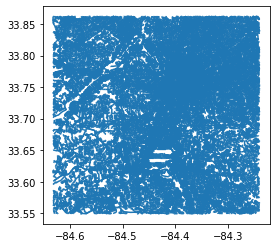

In [14]:
osm_links.plot()

In [16]:
cols = ['A','B','osmid','name','highway','highway_1','oneway','bicycle','footway','geometry']
osm_links = osm_links[cols]

In [19]:
osm_nodes.to_file(f'base_shapefiles/osm/osm_network_{studyareaname}.gpkg',layer='nodes',driver='GPKG')

In [20]:
osm_links.to_file(f'base_shapefiles/osm/osm_network_{studyareaname}.gpkg',layer='links',driver='GPKG')

Sometimes, there are duplicate attribute names in OSM. The below code drops duplicate column names by first appearance

In [16]:
#get rid of duplicate columns names
#overpass_links = overpass_links.iloc[:,overpass_links.columns.str.lower().duplicated(keep='first') == False]
